In [ ]:
# Import fundamental packages
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# Mount the Google Drive into Colab to use the drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The location of the csv file in Google Drive
csv_location = './drive/MyDrive/Datasets/CSE445/house_4/'

In [ ]:
sorted(os.listdir(csv_location))

['channel_1.csv']

In [ ]:
dataframes = []
for filename in sorted(os.listdir(csv_location)):
  # if filename == 'channel_1.csv': continue
  dataframe = pd.read_csv(csv_location+'/'+filename)
  dataframe.columns = ['timestamp', 'load_consumption']
  dataframe["timestamp"] = pd.to_datetime(dataframe["timestamp"],unit='s')
  dataframe = dataframe.set_index("timestamp")
  dataframes.append(dataframe)

# Model: AutoARIMA

In [ ]:

def calculate_r_squared(actual, predicted):
    mean_actual = np.mean(actual)
    ss_total = np.sum((actual - mean_actual) ** 2)
    ss_residual = np.sum((actual - predicted) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

def calculate_mean_absolute_error(actual, predicted):
    mae = np.mean(np.abs(actual - predicted))
    return mae

def calculate_mean_absolute_percentage_error(actual, predicted):
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

def calculate_mean_squared_error(actual, predicted):
    mse = np.mean((actual - predicted) ** 2)
    return mse

def calculate_root_mean_squared_error(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    return rmse

def calculate_normalized_root_mean_squared_error(actual, predicted):
    nrmse = np.sqrt(np.mean((actual - predicted) ** 2)) / (np.max(actual) - np.min(actual))
    return nrmse

def calculate_aic(training_data, predicted_data, num_params):
    residuals = predicted_data - training_data
    sse = np.sum(residuals**2)
    n = len(training_data)
    aic = n * np.log(sse/n) + 2 * num_params
    return aic

def calculate_bic(training_data, predicted_data, num_params):
    residuals = predicted_data - training_data
    sse = np.sum(residuals**2)
    n = len(training_data)
    bic = n * np.log(sse/n) + num_params * np.log(n)
    return bic

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.6 MB/s eta 0:00:00


In [ ]:
from pmdarima.arima import auto_arima

Total training datapoints: 76
Total testing datapoints: 19


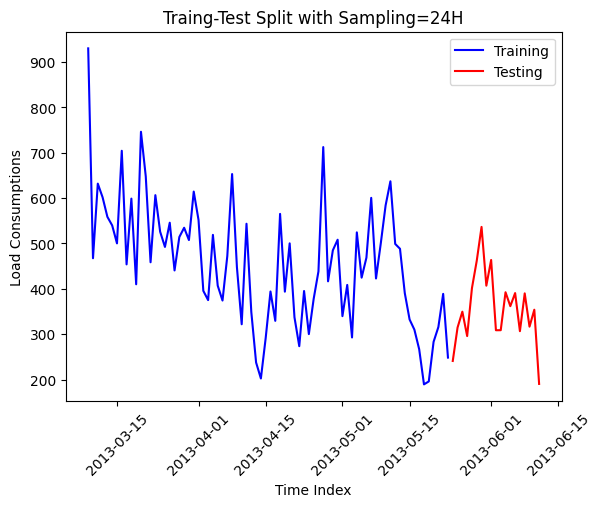

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=935.075, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=958.928, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=940.387, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=933.252, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=957.240, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=935.149, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=932.931, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=934.931, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=934.931, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=938.850, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=936.854, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.917 seconds
                               SARIMAX Results                                
Dep. Variable:           

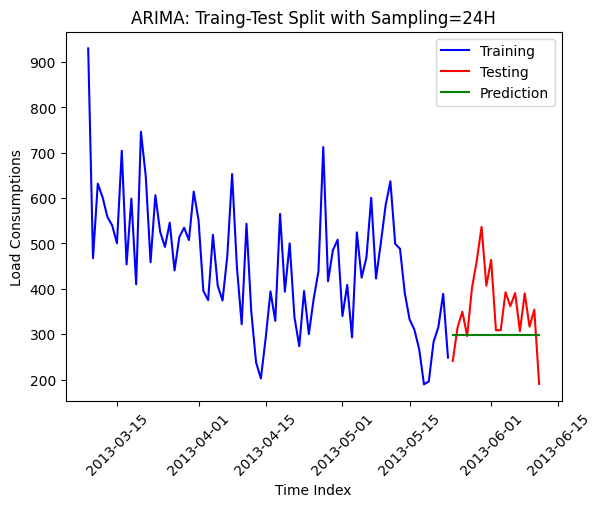

R-Squared: -0.58
Mean Absolute Error: 77.5022
Mean Absolute Percentage Error: 20.63
Mean Squared Error: 9841.93
Root Mean Squared Error: 99.21
Normalized Root Mean Squared Error: 0.29

 -0.58
 77.5022
 20.63
 9841.93
 99.21
 0.29


In [ ]:
resample_rule='24H'
target_channel = 0
current_in_hand_data_working=(dataframes[target_channel][:int(len(dataframes[target_channel])*0.6)]).resample(resample_rule).mean()

# Train Test Split 80-20
data_to_train_on = current_in_hand_data_working[0:int(len(current_in_hand_data_working)*0.8)]
data_to_test_on = current_in_hand_data_working[int(len(current_in_hand_data_working)*0.8):]
print("Total training datapoints:", len(data_to_train_on))
print("Total testing datapoints:", len(data_to_test_on))

# Plot the training+testing figure
plt.plot(data_to_train_on.index, data_to_train_on['load_consumption'], color='blue', label='Training')
plt.plot(data_to_test_on.index, data_to_test_on['load_consumption'], color='red', label='Testing')
plt.title('Traing-Test Split with Sampling='+resample_rule)
plt.xlabel('Time Index')
plt.ylabel('Load Consumptions')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Get the y-values
y_train = np.nan_to_num(data_to_train_on.load_consumption.values, nan=0.0)
y_test = np.nan_to_num(data_to_test_on.load_consumption.values, nan=0.0)

# Run AutoArima
model = auto_arima(
    y_train, # Using full data, because the last results will be used for validation
    X=None,
    start_p=1,
    d=None,  # Must, in order to iterate over 'd' (number of differencing)
    start_q=1,
    max_p=5,
    max_d=5,
    max_q=5,
    start_P=1,
    D=None,
    start_Q=1,
    max_P=5,
    max_D=5,
    max_Q=5,
    max_order=200,
    m=1,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    alpha=0.05,
    test='adf',
    seasonal_test='ocsb',
    stepwise=True,
    n_jobs=1,
    start_params=None,
    trend=None,
    method='lbfgs',
    maxiter=50,
    offset_test_args=None,
    seasonal_test_args=None,
    suppress_warnings=True,
    error_action='trace',
    trace=True,
    random=False,
    random_state=None,
    n_fits=10,
    return_valid_fits=False,
    out_of_sample_size=0,
    scoring='mse',
    scoring_args=None,
    with_intercept="auto",
    sarimax_kwargs=None
)
print(model.summary())

forecasts = model.predict(len(y_test))

# Plot the training+testing=prediction figure
plt.plot(data_to_train_on.index, data_to_train_on['load_consumption'], color='blue', label='Training')
plt.plot(data_to_test_on.index, data_to_test_on['load_consumption'], color='red', label='Testing')
plt.plot(data_to_test_on.index, forecasts, color='green', label='Prediction')
plt.title('ARIMA: Traing-Test Split with Sampling='+resample_rule)
plt.xlabel('Time Index')
plt.ylabel('Load Consumptions')
plt.legend()
plt.xticks(rotation=45)
plt.show()

r_squared = calculate_r_squared(data_to_test_on['load_consumption'], forecasts)
mae = calculate_mean_absolute_error(data_to_test_on['load_consumption'], forecasts)
mape = calculate_mean_absolute_percentage_error(data_to_test_on['load_consumption'], forecasts)
mse = calculate_mean_squared_error(data_to_test_on['load_consumption'], forecasts)
rmse = calculate_root_mean_squared_error(data_to_test_on['load_consumption'], forecasts)
nrmse = calculate_normalized_root_mean_squared_error(data_to_test_on['load_consumption'], forecasts)

print("R-Squared:", format(r_squared, '.2f'))
print("Mean Absolute Error:", format(mae, '.4f'))
print("Mean Absolute Percentage Error:", format(mape, '.2f'))
print("Mean Squared Error:", format(mse, '.2f'))
print("Root Mean Squared Error:", format(rmse, '.2f'))
print("Normalized Root Mean Squared Error:", format(nrmse, '.2f'))


print()

print("", format(r_squared, '.2f'))
print("", format(mae, '.4f'))
print("", format(mape, '.2f'))
print("", format(mse, '.2f'))
print("", format(rmse, '.2f'))
print("", format(nrmse, '.2f'))

# Model: LSTM

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

resample_rule='1H'
target_channel = 0
current_in_hand_data_working=(dataframes[target_channel][:int(len(dataframes[target_channel])*0.6)]).resample(resample_rule).mean()
timeseries = current_in_hand_data_working['load_consumption'].values.reshape(-1, 1)

# train-test split for time series
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).float(), torch.tensor(y).float()

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

X_train = X_train.to(device)
y_train = y_train
X_test = X_test.to(device)
y_test = y_test

class RNNConfig(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = RNNConfig().to(device)

Using cuda device


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [ ]:
n_epochs = 8000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device))
        train_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_train.cpu()))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_test.cpu()))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 578.7784, test RMSE 448.3931
Epoch 100: train RMSE 527.4342, test RMSE 395.7622
Epoch 200: train RMSE 480.7001, test RMSE 348.9617
Epoch 300: train RMSE 438.7003, test RMSE 309.2655
Epoch 400: train RMSE 405.1384, test RMSE 281.7267


In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = (model(X_train).cpu())[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    predx = model(X_test)
    test_plot[train_size+lookback:len(timeseries)] = (predx.cpu())[:, -1, :]
# plot

# Train Test Split 80-20
data_to_train_on = current_in_hand_data_working[0:train_size]
data_to_test_on = current_in_hand_data_working[train_size:]

# Find forecasted values
forecasts = test_plot.reshape(-1)
forecasts = forecasts[~np.isnan(forecasts)]
forecasts = np.concatenate((data_to_test_on['load_consumption'][:lookback], forecasts))

# Plot the training+testing=prediction figure
plt.plot(data_to_train_on.index, data_to_train_on['load_consumption'], color='blue', label='Training')
plt.plot(data_to_test_on.index, data_to_test_on['load_consumption'], color='red', label='Testing')
plt.plot(data_to_test_on.index, forecasts, color='green', label='Prediction')
plt.title('LSTM: Traing-Test Split with Sampling='+resample_rule)
plt.xlabel('Time Index')
plt.ylabel('Load Consumptions')
plt.legend()
plt.xticks(rotation=45)
plt.show()

r_squared = calculate_r_squared(data_to_test_on['load_consumption'], forecasts)
mae = calculate_mean_absolute_error(data_to_test_on['load_consumption'], forecasts)
mape = calculate_mean_absolute_percentage_error(data_to_test_on['load_consumption'], forecasts)
mse = calculate_mean_squared_error(data_to_test_on['load_consumption'], forecasts)
rmse = calculate_root_mean_squared_error(data_to_test_on['load_consumption'], forecasts)
nrmse = calculate_normalized_root_mean_squared_error(data_to_test_on['load_consumption'], forecasts)

print("R-Squared:", format(r_squared, '.2f'))
print("Mean Absolute Error:", format(mae, '.4f'))
print("Mean Absolute Percentage Error:", format(mape, '.2f'))
print("Mean Squared Error:", format(mse, '.2f'))
print("Root Mean Squared Error:", format(rmse, '.2f'))
print("Normalized Root Mean Squared Error:", format(nrmse, '.2f'))

print()

print("", format(r_squared, '.2f'))
print("", format(mae, '.4f'))
print("", format(mape, '.2f'))
print("", format(mse, '.2f'))
print("", format(rmse, '.2f'))
print("", format(nrmse, '.2f'))



# Model: XGBOOST

Total training datapoints: 1796
Total testing datapoints: 450
>expected=236.3, predicted=286.2
>expected=272.7, predicted=328.4
>expected=184.2, predicted=650.3
>expected=195.9, predicted=225.6
>expected=186.5, predicted=204.5
>expected=188.4, predicted=207.9
>expected=257.0, predicted=210.6
>expected=268.2, predicted=288.3
>expected=284.2, predicted=321.7
>expected=296.0, predicted=621.9
>expected=273.4, predicted=349.6
>expected=215.8, predicted=298.1
>expected=244.2, predicted=225.6
>expected=306.9, predicted=401.1
>expected=206.5, predicted=459.5
>expected=185.4, predicted=248.8
>expected=178.5, predicted=173.0
>expected=261.0, predicted=384.8
>expected=244.8, predicted=241.3
>expected=264.9, predicted=288.6
>expected=265.5, predicted=324.2
>expected=191.1, predicted=274.2
>expected=187.0, predicted=202.1
>expected=184.0, predicted=286.3
>expected=188.7, predicted=202.7
>expected=283.3, predicted=221.9
>expected=228.1, predicted=485.9
>expected=344.6, predicted=442.6
>expected=250.

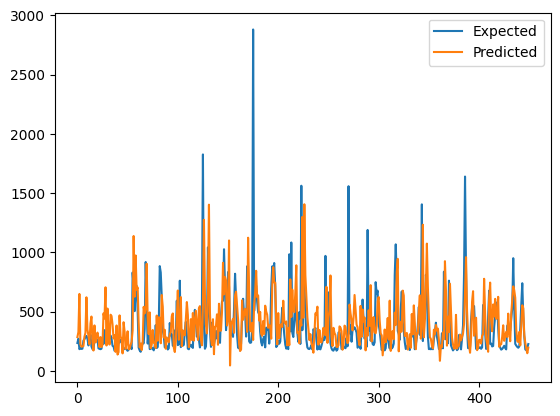

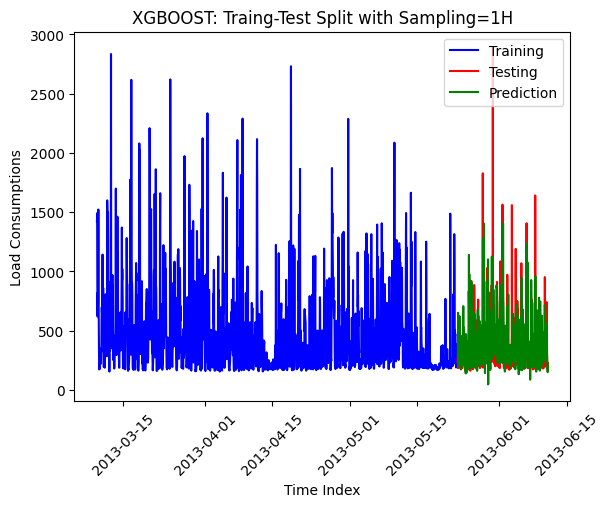

R-Squared: -0.17
Mean Absolute Error: 175.3887
Mean Absolute Percentage Error: 51.14
Mean Squared Error: 81286.38
Root Mean Squared Error: 285.11
Normalized Root Mean Squared Error: 0.10

 -0.17
 175.3887
 51.14
 81286.38
 285.11
 0.10


In [ ]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

resample_rule='1H'
target_channel = 0
current_in_hand_data_working=(dataframes[target_channel][:int(len(dataframes[target_channel])*0.6)]).resample(resample_rule).mean()

# Train Test Split 80-20
data_to_train_on = current_in_hand_data_working[0:int(len(current_in_hand_data_working)*0.8)]
data_to_test_on = current_in_hand_data_working[int(len(current_in_hand_data_working)*0.8):]
print("Total training datapoints:", len(data_to_train_on))
print("Total testing datapoints:", len(data_to_test_on))

# Get the y-values
y_train = np.nan_to_num(data_to_train_on.load_consumption.values, nan=0.0)
y_test = np.nan_to_num(data_to_test_on.load_consumption.values, nan=0.0)

# load the dataset
# transform the time series data into supervised learning
data = series_to_supervised(current_in_hand_data_working.values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, len(y_test))
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

forecasts = yhat

# Plot the training+testing=prediction figure
plt.plot(data_to_train_on.index, data_to_train_on['load_consumption'], color='blue', label='Training')
plt.plot(data_to_test_on.index, data_to_test_on['load_consumption'], color='red', label='Testing')
plt.plot(data_to_test_on.index, forecasts, color='green', label='Prediction')
plt.title('XGBOOST: Traing-Test Split with Sampling='+resample_rule)
plt.xlabel('Time Index')
plt.ylabel('Load Consumptions')
plt.legend()
plt.xticks(rotation=45)
plt.show()

r_squared = calculate_r_squared(data_to_test_on['load_consumption'], forecasts)
mae = calculate_mean_absolute_error(data_to_test_on['load_consumption'], forecasts)
mape = calculate_mean_absolute_percentage_error(data_to_test_on['load_consumption'], forecasts)
mse = calculate_mean_squared_error(data_to_test_on['load_consumption'], forecasts)
rmse = calculate_root_mean_squared_error(data_to_test_on['load_consumption'], forecasts)
nrmse = calculate_normalized_root_mean_squared_error(data_to_test_on['load_consumption'], forecasts)

print("R-Squared:", format(r_squared, '.2f'))
print("Mean Absolute Error:", format(mae, '.4f'))
print("Mean Absolute Percentage Error:", format(mape, '.2f'))
print("Mean Squared Error:", format(mse, '.2f'))
print("Root Mean Squared Error:", format(rmse, '.2f'))
print("Normalized Root Mean Squared Error:", format(nrmse, '.2f'))

print()

print("", format(r_squared, '.2f'))
print("", format(mae, '.4f'))
print("", format(mape, '.2f'))
print("", format(mse, '.2f'))
print("", format(rmse, '.2f'))
print("", format(nrmse, '.2f'))